## Environment setup

In [1]:
# !git clone https://github.com/facebookresearch/detectron2

In [2]:
!python -m pip install pyyaml==5.1;

Defaulting to user installation because normal site-packages is not writeable
  Using cached PyYAML-5.1-cp311-cp311-win_amd64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.6 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.3.1 which is incompatible.
langchain 0.1.16 requires PyYAML>=5.3, but you have pyyaml 5.1 which is incompatible.
langchain-community 0.0.33 requires PyYAML>=5.3, but you have pyyaml 5.1 which is incompatible.
langchain-core 0.1.43 requires PyYAML>=5.3, but you have pyyaml 5.1 which is incompatible.
llama-index-core 0.10.29 requires PyYAML>=6.0.1, but you have pyyaml 5.1 which is incompatible.
roboflow 1.0.5 requires PyYAML>=5.3.1, but you have pyyaml 5.1 which is incompatible.
ultralytics 8.1.29 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
yolov5 7.0.11 requires PyYAML>=5.3.1, but you have pyyaml 5.1 which is incompatible.


In [3]:
import sys, os, distutils.core

In [4]:
dist = distutils.core.run_setup("detectron2/setup.py")

In [5]:
dist.install_requires

['Pillow>=7.1',
 'matplotlib',
 'pycocotools>=2.0.2',
 'termcolor>=1.1',
 'yacs>=0.1.8',
 'tabulate',
 'cloudpickle',
 'tqdm>4.29.0',
 'tensorboard',
 'fvcore<0.1.6,>=0.1.5',
 'iopath<0.1.10,>=0.1.7',
 'dataclasses; python_version < "3.7"',
 'omegaconf<2.4,>=2.1',
 'hydra-core>=1.1',
 'black',
 'packaging']

In [6]:
!python -m pip install Pillow>=7.1

In [7]:
!python -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!python -m pip install pycocotools>=2.0.2 termcolor>=1.1 yacs>=0.1.8 tabulate cloudpickle tqdm>4.29.0 tensorboard

In [9]:
!python -m pip install fvcore<0.1.6,>=0.1.5

The system cannot find the file specified.


In [10]:
!python -m pip install iopath<0.1.10,>=0.1.7 dataclasses;

The system cannot find the file specified.


In [11]:
!pip install omegaconf<2.4;

The system cannot find the file specified.


In [12]:
sys.path.insert(0, os.path.abspath('./detectron2'))

## **Importing libraries**

In [13]:
import torch, detectron2
#nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.0 ; cuda:  cpu
detectron2: 0.6


In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\Prakhar Jadaun\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\Prakhar Jadaun\.matplotlib
Using fontManager instance from C:\Users\Prakhar Jadaun\.matplotlib\fontlist-v330.json


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from detectron2.structures import BoxMode

In [16]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

## **Registering the dataset**

In [17]:
def get_sign_dicts(directory):
    classes = ['leopard']
    dataset_dicts = []
    img_id = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            # print('opened file')
            img_anns = json.load(f)
            # print(img_anns['images'])
            # print(img_anns['file_name'])

        record = {}
        temp = img_anns['imagePath'].split('\\')
        # print(temp[-1])
        filename = os.path.join(directory, temp[-1])
        # filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = img_id
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        img_id += 1
    return dataset_dicts

In [18]:
for d in ["train", "val"]:
    DatasetCatalog.register("leopard_segmentation_test4_" + d, lambda d=d: get_sign_dicts('Training output\Detectron2 output\dataset\\' + d))
    MetadataCatalog.get("leopard_segmentation_test4_" + d).set(thing_classes=['leopard'])

In [20]:
leopard_segmentation_test_metadata = MetadataCatalog.get("leopard_segmentation_test4_val")

In [21]:
cfg = get_cfg()
cfg.OUTPUT_DIR = 'Training output\Detectron2 output\model_eval_output'
cfg.merge_from_file("Training output\Detectron2 output\leopard_segmentation_config.yml")
cfg.MODEL.WEIGHTS = 'Training output\Detectron2 output\model.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.DATASETS.TEST = ('leopard_segmentation_test4_val',)
cfg.DATASETS.TRAIN = ("leopard_segmentation_test4_train",)

In [22]:
cfg.MODEL.DEVICE = "cpu"

In [23]:
predictor = DefaultPredictor(cfg)

[04/17 00:33:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from Training output\Detectron2 output\model.pth ...
[Checkpointer] Loading from Training output\Detectron2 output\model.pth ...


In [24]:
dataset_dicts = get_sign_dicts(r'Training output\Detectron2 output\dataset\val')

C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prak

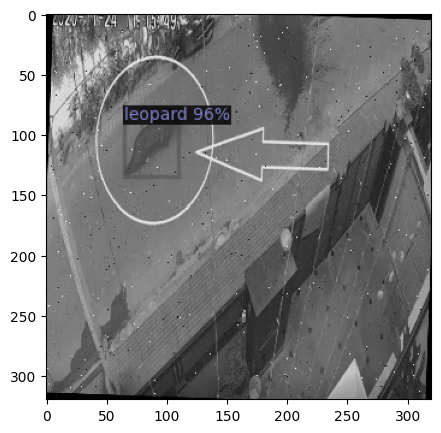

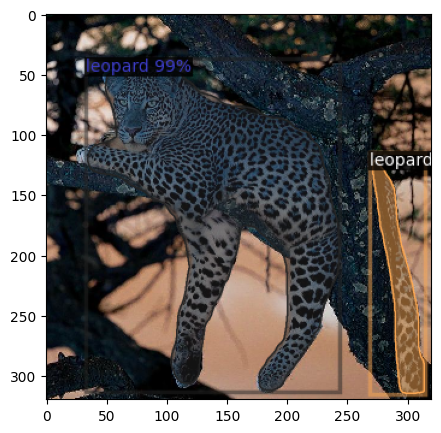

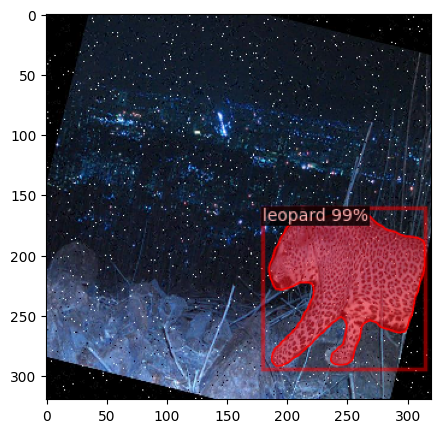

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.5.
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prakhar Jadaun\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Users\\Prak

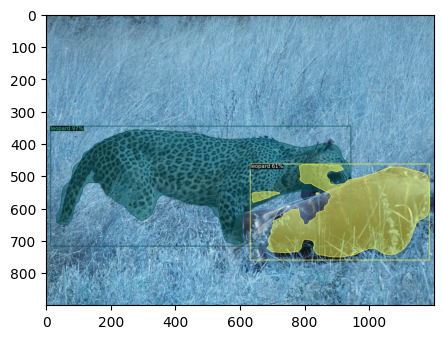

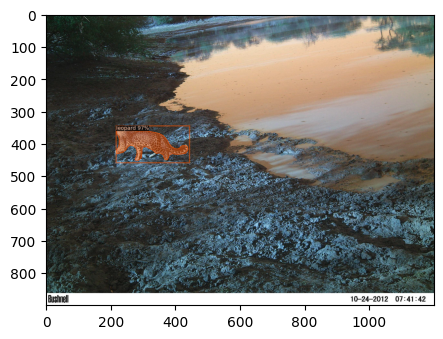

In [25]:
for d in random.sample(dataset_dicts,5):
    # img = cv2.imread(d['file_name'])
    # # print(img.shape)
    # outputs = predictor(img)

    # v = Visualizer(cv2.cvtColor(img, cv2.COLOR_RGB2BGR),MetadataCatalog.get('leopard_segmentation_test2_train' ),scale=0.3)
    # out = v.draw_instance_predictions(outputs['instances'].to("cpu"))
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leopard_segmentation_test_metadata,
                   scale=0.5,
                  #  instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(out.get_image(),cv2.COLOR_BGR2RGB))
    plt.show()

In [28]:
for d in random.sample(dataset_dicts,1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.

In [44]:
d['annotations'][0]['bbox']

[1657.03125, 556.25, 2327.34375, 1051.5625]

In [53]:
list(outputs['instances'].pred_boxes[0].tensor.numpy()[0])

[1652.5664, 580.09534, 2303.5679, 1033.4949]

In [39]:
def calculate_iou(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Bounding boxes are in format [x_min, y_min, x_max, y_max].
    """
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    
    # Calculate intersection area
    x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    intersection_area = x_overlap * y_overlap
    
    # Calculate area of each bounding box
    bbox1_area = (x1_max - x1_min) * (y1_max - y1_min)
    bbox2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calculate union area
    union_area = bbox1_area + bbox2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou
# Bounding box coordinates
# bbox1 = [1652.5664, 580.0953, 2303.5679, 1033.4949]
# bbox2 = [1657.03125, 556.25, 2327.34375, 1051.5625]

# # Calculate IoU
# iou = calculate_iou(bbox1, bbox2)
# print("IoU:", iou)


In [57]:
TOTAL_IOU = []
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    TOTAL_IOU.append(calculate_iou(list(outputs['instances'].pred_boxes[0].tensor.numpy()[0]),d['annotations'][0]['bbox']))

In [58]:
sum(TOTAL_IOU)/len(TOTAL_IOU)

0.8077628959476659

In [137]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("leopard_segmentation_test4_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "leopard_segmentation_test4_val")

[03/21 13:41:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/21 13:41:21 d2.evaluation.coco_evaluation]: Trying to convert 'leopard_segmentation_test4_val' to COCO format ...
[03/21 13:41:21 d2.data.datasets.coco]: Converting annotations of dataset 'leopard_segmentation_test4_val' to COCO format ...)
[03/21 13:41:21 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/21 13:41:21 d2.data.datasets.coco]: Conversion finished, #images: 150, #annotations: 155
[03/21 13:41:21 d2.data.datasets.coco]: Caching COCO format annotations at './output\leopard_segmentation_test4_val_coco_format.json' ...
[03/21 13:41:22 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  leopard   | 155          |
|            |              |
[03/21 13:41:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length

In [138]:
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/21 13:49:06 d2.evaluation.evaluator]: Start inference on 150 batches
[03/21 13:49:51 d2.evaluation.evaluator]: Inference done 11/150. Dataloading: 0.0009 s/iter. Inference: 3.4088 s/iter. Eval: 0.0038 s/iter. Total: 3.4135 s/iter. ETA=0:07:54
[03/21 13:49:58 d2.evaluation.evaluator]: Inference done 13/150. Dataloading: 0.0009 s/iter. Inference: 3.4331 s/iter. Eval: 0.0034 s/iter. Total: 3.4376 s/iter. ETA=0:07:50
[03/21 13:50:04 d2.evaluation.evaluator]: Inference done 15/150. Dataloading: 0.0009 s/iter. Inference: 3.4075 s/iter. Eval: 0.0032 s/iter. Total: 3.4119 s/iter. ETA=0:07:40
[03/21 13:50:12 d2.evaluation.evaluator]: Inference done 17/150. Dataloading: 0.0010 s/iter. Inference: 3.4912 s/iter. Eval: 0.0031 s/iter. Total: 3.4956 s/iter. ETA=0:07:44
[03/21 13:50:20 d2.evaluation.evaluator]: Inference done 19/150. Dataloading: 0.0010 s/iter. Inference: 3.5257 s/iter. Eval: 0.0032 s/iter. Total: 3.5303 s/iter. ETA=0:07:42
[03/21 13:50:27 d2.evaluation.evaluator]: Inference done 

In [32]:
import cv2

In [120]:
from shapely.geometry import Polygon
from shapely.validation import explain_validity

In [123]:
# for d in random.sample(dataset_dicts,1):
#     # print(d)
#     g_truth = np.array(d['annotations'][0]['segmentation'])
    
#     g_truth = g_truth.reshape(int(g_truth.shape[1]/2),2)
#     # print(g_truth)
#     # print(g_truth.shape)
#     g_truth = Polygon(g_truth)
#     # print(g_truth.area)
#     # break
#     im = cv2.imread(d['file_name'])
#     # print(im.shape)
#     outputs = predictor(im)

#     mask = outputs['instances'][0].pred_masks.cpu().numpy()
#     print(mask.shape)
#     # print(mask)

#     # Convert mask to list of coordinates
#     coordinates = np.argwhere(mask[0])
#     print(coordinates)
#     x, y = coordinates[:, 0], coordinates[:, 1]

#     # Calculate area using Shapely
#     pred_polygon = Polygon([(y[i], x[i]) for i in range(len(x))])
#     # pred_polygon.area

#     # Check validity of geometries
#     if not g_truth.is_valid:
#         print("Ground truth geometry is invalid:", explain_validity(g_truth))
#         # Attempt to fix invalid geometry
#         g_truth = g_truth.buffer(0)

#     if not pred_polygon.is_valid:
#         print("Predicted polygon geometry is invalid:", explain_validity(pred_polygon))
#         # Attempt to fix invalid geometry
#         pred_polygon = pred_polygon.buffer(0)

#     intersection = g_truth.intersection(pred_polygon).area
#     union_area = g_truth.union(pred_polygon).area
#     if union_area == 0:
#         iou = 0  # Avoid division by zero
#     else:
#         iou = intersection / union_area
    
#     print("IOU:", iou)

(1, 1347, 2400)
[[ 496 1220]
 [ 496 1221]
 [ 496 1222]
 ...
 [ 882 1164]
 [ 882 1165]
 [ 882 1166]]
Predicted polygon geometry is invalid: Self-intersection[1166.01008382438 881.927919329405]
IOU: 0.16275689968824975


# **SAMPLE**

In [36]:
# for d in random.sample(dataset_dicts, 1):
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im)

#     # Assuming you have already loaded the model, config, and obtained the mask prediction
#     # im = cv2.imread(path_to_image)
#     mask = outputs['instances'][0].pred_masks.cpu().numpy()

#     # Handle potential issues with multiple masks (if applicable)
#     if len(mask.shape) > 2:
#         mask = mask[0, :, :]  # Assuming you want the first mask (modify if needed)

#     # Resize the mask to match the image size (if necessary)
#     if mask.shape[:2] != im.shape[:2]:
#         mask = cv2.resize(mask, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)

#     # Apply thresholding (optional, adjust threshold if needed)
#     thresh, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

#     # Invert mask if necessary
#     # inverted_mask = 255 - mask  # Uncomment if your mask is inverted

#     # Option 1: Apply mask to grayscale image for better visibility
#     gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#     masked_image = cv2.bitwise_and(gray_image, gray_image, mask=binary_mask.astype(np.uint8))

#     # Option 2: Apply mask to each color channel separately (experimental)
#     # masked_image = im.copy()
#     # for i in range(3):
#     #     masked_image[:,:,i] = cv2.bitwise_and(im[:,:,i], im[:,:,i], mask=binary_mask.astype(np.uint8))

#     # Optional: Apply transparency (adjust alpha value as needed)
#     alpha = 0.5  # Transparency level (0 for fully transparent, 1 for fully opaque)
#     foreground = masked_image if len(mask.shape) == 2 else cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR)  # Handle grayscale image
#     background = im.copy()  # Or any background image you prefer
#     composite = cv2.convertScaleAbs(foreground, alpha=alpha) + cv2.convertScaleAbs(background, alpha=1-alpha)

#     # Display or save the masked image
#     cv2.imshow("Masked Image", composite)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

#     # To save the masked image:
#     # cv2.imwrite("masked_image.png", composite)


In [50]:
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    # print(outputs['instances'][0].pred_masks)


    # # Assuming you have already loaded the model, config, and obtained the mask prediction
    # im = cv2.imread(path_to_image)
    mask = outputs['instances'][0].pred_masks.cpu().numpy()  # Access the mask data
    print(mask)

    # Handle potential issues with multiple masks (if applicable)
    if len(mask.shape) > 2:  # Check if there are multiple masks
        mask = mask[0, :, :]  # Assuming you want the first mask (modify if needed)

    # Resize the mask to match the image size (if necessary)
    if mask.shape[:2] != im.shape[:2]:
        mask = cv2.resize(mask, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply the mask using bitwise AND operation
    masked_image = cv2.bitwise_and(im, mask, mask=mask.astype(np.uint8))

    # Optional: Apply transparency (adjust alpha value as needed)
    alpha = 0.5  # Transparency level (0 for fully transparent, 1 for fully opaque)
    foreground = masked_image
    background = im.copy()  # Or any background image you prefer
    composite = cv2.convertScaleAbs(foreground, alpha=alpha) + cv2.convertScaleAbs(background, alpha=1-alpha)

    # Display or save the masked image
    cv2.imshow("Masked Image", composite)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # To save the masked image:
    # cv2.imwrite("masked_image.png", composite)

    # break
    # v = Visualizer(im[:, :, ::-1],
    #                metadata= leopard_segmentation_test2_metadata,
    #                scale=0.5,
    #               #  instance_mode=ColorMode.IMAGE_BW
    # )
    # out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # pred_img = cv2.cvtColor(out.get_image(),cv2.COLOR_BGR2RGB)
    # plt.imshow(pred_img)


[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'bitwise_and'
> Overload resolution failed:
>  - src2 data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src2'


In [54]:
import matplotlib.pyplot as plt

In [58]:
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    # print(im)
    outputs = predictor(im)

    mask = outputs['instances'][0].pred_masks.cpu().numpy()  # Access the mask data
    print(mask.shape)
    im = cv2.bitwise_and(im, im, mask=mask.astype(np.uint8))
    # print(im)

    masked = np.ma.masked_where(mask==1,mask)
    plt.imshow(im, 'gray', interpolation='none')
    # plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
    plt.show()
    

(1, 640, 640)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


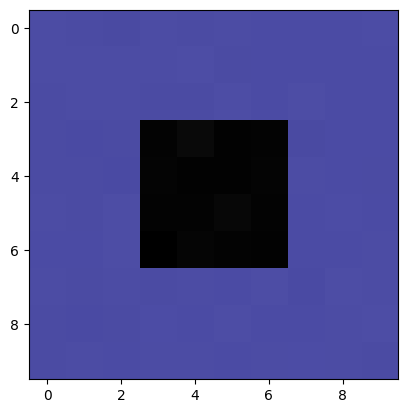

In [47]:
import numpy as np
mask = np.ones((10,10))
mask[3:-3, 3:-3] = 0 # white square in black background
# print(mask)
im = mask + np.random.randn(10,10) * 0.01 # random image
# print(im)
masked = np.ma.masked_where(mask == 0, mask)

import matplotlib.pyplot as plt
plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
plt.show()


In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Create mask with dimensions (1, 640, 640)
mask = np.ones((1, 640, 640))
mask[0, 150:490, 150:490] = 0  # White square in black background

# Create random image with dimensions (3, 640, 640)
im = np.random.randn(3, 640, 640) * 0.01

# Ensure compatibility between mask and image shapes
if mask.shape[1:] != im.shape[1:]:
    raise ValueError("Mask and image shapes must match for spatial dimensions.")
    print(f"Mask shape: {mask.shape}")
    print(f"Image shape: {im.shape}")

# Apply masking to each color channel independently
masked_image = np.ma.masked_array(im, mask=mask)

# Visualize the masked image
plt.figure()
plt.imshow(masked_image, cmap='jet', interpolation='none', alpha=0.7)
plt.show()

MaskError: Mask and data not compatible: data size is 1228800, mask size is 409600.